In [65]:
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from pprint import pprint
import matplotlib.image as mpimg
import matplotlib.patches as patches
from io import BytesIO
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.markers import MarkerStyle
from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen, add_image
from matplotlib.font_manager import FontProperties
from matplotlib import rcParams
from matplotlib.patheffects import withStroke, Normal
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer.utils import FontManager
import matplotlib.patheffects as path_effects
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from sklearn.cluster import KMeans
import warnings
from highlight_text import ax_text, fig_text
from PIL import Image
from urllib.request import urlopen
import os
import time
from unidecode import unidecode
from scipy.spatial import ConvexHull

#modify the dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


#custom colors

green = '#69f900'
red = '#ff4b44'
blue = '#00a0de'
violet = '#a369ff'
bg_color= '#f5f5f5'
line_color= '#000000'
# bg_color= '#000000'
# line_color= '#ffffff'
col1 = '#ff4b44'
col2 = '#00a0de'

In [66]:
match_html_path = r"C:\Users\gerald wangai\Downloads\Paris Saint-Germain 5-0 Inter - Champions League 2024_2025 Live.html"
# Put the Fotmob matchId here
fotmob_matchId = 4506298

def extract_json_from_html(html_path, save_output=False):
    with open(html_path, 'r', encoding='utf-8') as html_file:
        html = html_file.read()

    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for JSON parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save JSON data to txt
        output_file = open(f"{html_path}.txt", "wt", encoding='utf-8')
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

def filter_json_data(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_data = data["matchCentreData"]["events"]
    teams_data = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_data = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_data, players_df, teams_data


json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_data, players_df, teams_data = filter_json_data(data)

df = pd.DataFrame(events_data)
dfp = pd.DataFrame(players_df)


#create csv files

df.to_csv("E:\important\Coding\Python Coding\Football Analytics/event_data.csv")
dfp.to_csv("E:\important\Coding\Python Coding\Football Analytics/player_data.csv")

df=pd.read_csv("E:\important\Coding\Python Coding\Football Analytics/event_data.csv")

dfp=pd.read_csv("E:\important\Coding\Python Coding\Football Analytics/player_data.csv")


# Extract the 'displayName' value
df['type'] = df['type'].str.extract(r"'displayName': '([^']+)")
df['outcomeType'] = df['outcomeType'].str.extract(r"'displayName': '([^']+)")
df['period'] = df['period'].str.extract(r"'displayName': '([^']+)")
df['qualifiers'] = df['qualifiers'].str.extract(r"'displayName': '([^']+)")

In [67]:
df.head()

,Unnamed: 0,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,relatedEventId,relatedPlayerId,goalMouthZ,goalMouthY,isShot,blockedX,blockedY,isGoal,cardType
0,0,2.820408e+09,2,0,0.0,304,0.0,0.0,0,FirstHalf,Start,Successful,NaN,[],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2.820408e+09,2,0,0.0,75,0.0,0.0,0,FirstHalf,Start,Successful,NaN,[],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2.820408e+09,3,0,0.0,304,50.0,50.0,0,FirstHalf,Pass,Unsuccessful,PassEndY,"[91, 120, 128, 36, 37, 217, 218]",True,384887.0,78.3,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2.820408e+09,4,0,25.0,75,28.9,0.0,0,FirstHalf,Pass,Successful,PassEndY,"[91, 212, 36, 37, 216]",True,322153.0,53.6,18.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2.820408e+09,5,0,27.0,75,55.3,7.7,0,FirstHalf,BallTouch,Unsuccessful,StandingSave,"[91, 69]",True,296322.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
df.columns

Index(['Unnamed: 0', 'id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY',
       'relatedEventId', 'relatedPlayerId', 'goalMouthZ', 'goalMouthY',
       'isShot', 'blockedX', 'blockedY', 'isGoal', 'cardType'],
      dtype='object')

In [69]:
#columns_to_drop=['relatedEventId','relatedPlayerId', 'goalMouthZ', 'goalMouthY',
       #'isShot', 'blockedX', 'blockedY', 'isGoal', 'cardType']

In [70]:
df['teamId'].unique()

array([304,  75], dtype=int64)

In [71]:
psg_df=df[df['teamId']==304]

In [72]:
psg_df=pd.merge(psg_df, dfp, on='playerId')

In [73]:
psg_df.head()

,Unnamed: 0_x,id,eventId,minute,second,teamId_x,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,relatedEventId,relatedPlayerId,goalMouthZ,goalMouthY,isShot,blockedX,blockedY,isGoal,cardType,Unnamed: 0_y,shirtNo,name,position,height,weight,age,isFirstEleven,isManOfTheMatch,field,stats,subbedInPlayerId,subbedOutPeriod,subbedOutExpandedMinute,subbedInPeriod,subbedInExpandedMinute,subbedOutPlayerId,teamId_y
0,2,2.820408e+09,3,0,0.0,304,50.0,50.0,0,FirstHalf,Pass,Unsuccessful,PassEndY,"[91, 120, 128, 36, 37, 217, 218]",True,384887.0,78.3,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,17,Vitinha,MC,172,64,25,True,False,home,"{'possession': {'0': 1.0, '1': 3.0, '3': 3.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,304
1,5,2.820408e+09,5,0,29.0,304,38.2,80.6,0,FirstHalf,BallRecovery,Successful,NaN,[93],False,101949.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,5,Marquinhos,DC,183,75,31,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '3': 2.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,304
2,6,2.820408e+09,6,0,29.0,304,38.2,80.6,0,FirstHalf,Pass,Successful,StandingSave,"[91, 117, 127, 35, 38, 215, 218]",True,101949.0,15.1,48.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,5,Marquinhos,DC,183,75,31,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '3': 2.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,304
3,7,2.820408e+09,7,0,36.0,304,14.4,48.7,0,FirstHalf,Pass,Successful,PassEndY,"[91, 117, 30, 36, 37, 215, 218]",True,262515.0,15.2,74.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Gianluigi Donnarumma,GK,196,90,26,True,False,home,"{'totalSaves': {'77': 1.0, '83': 1.0}, 'collec...",NaN,NaN,NaN,NaN,NaN,NaN,304
4,8,2.820408e+09,8,0,43.0,304,16.9,71.9,0,FirstHalf,Pass,Successful,Chipped,"[91, 117, 124, 127, 36, 38, 216, 218]",True,432378.0,43.9,39.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,51,Willian Pacho,DC,188,81,23,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '3': 2.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,304


In [74]:
psg_df_pass_events=psg_df[psg_df['type']=='Pass']

In [75]:
psg_df_pass_events.head()

,Unnamed: 0_x,id,eventId,minute,second,teamId_x,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,relatedEventId,relatedPlayerId,goalMouthZ,goalMouthY,isShot,blockedX,blockedY,isGoal,cardType,Unnamed: 0_y,shirtNo,name,position,height,weight,age,isFirstEleven,isManOfTheMatch,field,stats,subbedInPlayerId,subbedOutPeriod,subbedOutExpandedMinute,subbedInPeriod,subbedInExpandedMinute,subbedOutPlayerId,teamId_y
0,2,2.820408e+09,3,0,0.0,304,50.0,50.0,0,FirstHalf,Pass,Unsuccessful,PassEndY,"[91, 120, 128, 36, 37, 217, 218]",True,384887.0,78.3,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,17,Vitinha,MC,172,64,25,True,False,home,"{'possession': {'0': 1.0, '1': 3.0, '3': 3.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,304
2,6,2.820408e+09,6,0,29.0,304,38.2,80.6,0,FirstHalf,Pass,Successful,StandingSave,"[91, 117, 127, 35, 38, 215, 218]",True,101949.0,15.1,48.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,5,Marquinhos,DC,183,75,31,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '3': 2.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,304
3,7,2.820408e+09,7,0,36.0,304,14.4,48.7,0,FirstHalf,Pass,Successful,PassEndY,"[91, 117, 30, 36, 37, 215, 218]",True,262515.0,15.2,74.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Gianluigi Donnarumma,GK,196,90,26,True,False,home,"{'totalSaves': {'77': 1.0, '83': 1.0}, 'collec...",NaN,NaN,NaN,NaN,NaN,NaN,304
4,8,2.820408e+09,8,0,43.0,304,16.9,71.9,0,FirstHalf,Pass,Successful,Chipped,"[91, 117, 124, 127, 36, 38, 216, 218]",True,432378.0,43.9,39.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,51,Willian Pacho,DC,188,81,23,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '3': 2.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,304
5,9,2.820408e+09,9,0,47.0,304,45.3,49.9,0,FirstHalf,Pass,Successful,PassEndY,"[91, 119, 117, 30, 124, 36, 38, 216, 218]",True,465388.0,54.7,47.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,87,João Neves,MC,174,66,20,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '3': 1.0, ...",444679.0,"{'value': 2, 'displayName': 'SecondHalf'}",86.0,NaN,NaN,NaN,304


In [76]:
psg_df_pass_events=psg_df_pass_events.loc[:, ~psg_df_pass_events.columns.isin(['relatedEventId','relatedPlayerId','goalMouthZ','isShot','blockedX','blockedY','cardType','isGoal'])]

In [77]:
psg_df_pass_events.head()

,Unnamed: 0_x,id,eventId,minute,second,teamId_x,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,goalMouthY,Unnamed: 0_y,shirtNo,name,position,height,weight,age,isFirstEleven,isManOfTheMatch,field,stats,subbedInPlayerId,subbedOutPeriod,subbedOutExpandedMinute,subbedInPeriod,subbedInExpandedMinute,subbedOutPlayerId,teamId_y
0,2,2.820408e+09,3,0,0.0,304,50.0,50.0,0,FirstHalf,Pass,Unsuccessful,PassEndY,"[91, 120, 128, 36, 37, 217, 218]",True,384887.0,78.3,100.0,NaN,6,17,Vitinha,MC,172,64,25,True,False,home,"{'possession': {'0': 1.0, '1': 3.0, '3': 3.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,304
2,6,2.820408e+09,6,0,29.0,304,38.2,80.6,0,FirstHalf,Pass,Successful,StandingSave,"[91, 117, 127, 35, 38, 215, 218]",True,101949.0,15.1,48.5,NaN,2,5,Marquinhos,DC,183,75,31,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '3': 2.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,304
3,7,2.820408e+09,7,0,36.0,304,14.4,48.7,0,FirstHalf,Pass,Successful,PassEndY,"[91, 117, 30, 36, 37, 215, 218]",True,262515.0,15.2,74.7,NaN,0,1,Gianluigi Donnarumma,GK,196,90,26,True,False,home,"{'totalSaves': {'77': 1.0, '83': 1.0}, 'collec...",NaN,NaN,NaN,NaN,NaN,NaN,304
4,8,2.820408e+09,8,0,43.0,304,16.9,71.9,0,FirstHalf,Pass,Successful,Chipped,"[91, 117, 124, 127, 36, 38, 216, 218]",True,432378.0,43.9,39.8,NaN,3,51,Willian Pacho,DC,188,81,23,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '3': 2.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,304
5,9,2.820408e+09,9,0,47.0,304,45.3,49.9,0,FirstHalf,Pass,Successful,PassEndY,"[91, 119, 117, 30, 124, 36, 38, 216, 218]",True,465388.0,54.7,47.3,NaN,7,87,João Neves,MC,174,66,20,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '3': 1.0, ...",444679.0,"{'value': 2, 'displayName': 'SecondHalf'}",86.0,NaN,NaN,NaN,304


In [78]:
periods=psg_df_pass_events['period'].unique()


In [79]:
periods

array(['FirstHalf', 'SecondHalf'], dtype=object)

In [80]:
types=psg_df['type'].unique()

In [81]:
types

array(['Pass', 'BallRecovery', 'BallTouch', 'Tackle', 'Foul', 'Aerial',
       'Dispossessed', 'MissedShots', 'Interception', 'SavedShot',
       'Clearance', 'Goal', 'BlockedPass', 'Challenge', 'CornerAwarded',
       'KeeperSweeper', 'OffsideProvoked', 'KeeperPickup', 'TakeOn',
       'Save', 'Card', 'SubstitutionOff', 'SubstitutionOn',
       'ShieldBallOpp', 'Claim'], dtype=object)

In [82]:
substitutions=psg_df[psg_df['type']=='SubstitutionOff']

In [83]:
substitutions

,Unnamed: 0_x,id,eventId,minute,second,teamId_x,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,relatedEventId,relatedPlayerId,goalMouthZ,goalMouthY,isShot,blockedX,blockedY,isGoal,cardType,Unnamed: 0_y,shirtNo,name,position,height,weight,age,isFirstEleven,isManOfTheMatch,field,stats,subbedInPlayerId,subbedOutPeriod,subbedOutExpandedMinute,subbedInPeriod,subbedInExpandedMinute,subbedOutPlayerId,teamId_y
559,1006,2.820424e+09,629,66,2.0,304,0.0,0.0,69,SecondHalf,SubstitutionOff,Successful,PlayerPosition,[214],False,433183.0,NaN,NaN,630.0,425366.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,14,Désiré Doué,FWR,181,79,20,True,True,home,"{'possession': {'1': 2.0, '2': 1.0, '4': 1.0, ...",425366.0,"{'value': 2, 'displayName': 'SecondHalf'}",69.0,NaN,NaN,NaN,304
657,1194,2.820426e+09,735,77,41.0,304,0.0,0.0,80,SecondHalf,SubstitutionOff,Successful,JerseyNumber,[214],False,395221.0,NaN,NaN,736.0,139186.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,25,Nuno Mendes,DL,180,70,22,True,False,home,"{'possession': {'1': 3.0, '3': 3.0, '7': 1.0, ...",139186.0,"{'value': 2, 'displayName': 'SecondHalf'}",80.0,NaN,NaN,NaN,304
740,1309,2.820427e+09,820,83,18.0,304,0.0,0.0,86,SecondHalf,SubstitutionOff,Successful,PlayerPosition,[214],False,370984.0,NaN,NaN,821.0,395802.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,7,Khvicha Kvaratskhelia,FWL,183,76,24,True,False,home,"{'possession': {'1': 2.0, '3': 1.0, '11': 1.0,...",395802.0,"{'value': 2, 'displayName': 'SecondHalf'}",86.0,NaN,NaN,NaN,304
742,1311,2.820427e+09,822,83,37.0,304,0.0,0.0,86,SecondHalf,SubstitutionOff,Successful,RelatedEventId,[214],False,294193.0,NaN,NaN,823.0,513665.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,8,Fabián Ruiz,MC,189,70,29,True,False,home,"{'possession': {'1': 3.0, '5': 2.0, '6': 1.0, ...",513665.0,"{'value': 2, 'displayName': 'SecondHalf'}",86.0,NaN,NaN,NaN,304
744,1313,2.820427e+09,824,83,39.0,304,0.0,0.0,86,SecondHalf,SubstitutionOff,Successful,JerseyNumber,[214],False,465388.0,NaN,NaN,825.0,444679.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,87,João Neves,MC,174,66,20,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '3': 1.0, ...",444679.0,"{'value': 2, 'displayName': 'SecondHalf'}",86.0,NaN,NaN,NaN,304


In [84]:
first_sub=substitutions['minute'].min()

In [85]:
first_sub

66

In [86]:
psg_df=psg_df[psg_df['minute']<=first_sub]

In [87]:
psg_df

,Unnamed: 0_x,id,eventId,minute,second,teamId_x,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,relatedEventId,relatedPlayerId,goalMouthZ,goalMouthY,isShot,blockedX,blockedY,isGoal,cardType,Unnamed: 0_y,shirtNo,name,position,height,weight,age,isFirstEleven,isManOfTheMatch,field,stats,subbedInPlayerId,subbedOutPeriod,subbedOutExpandedMinute,subbedInPeriod,subbedInExpandedMinute,subbedOutPlayerId,teamId_y
0,2,2.820408e+09,3,0,0.0,304,50.0,50.0,0,FirstHalf,Pass,Unsuccessful,PassEndY,"[91, 120, 128, 36, 37, 217, 218]",True,384887.0,78.3,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,17,Vitinha,MC,172,64,25,True,False,home,"{'possession': {'0': 1.0, '1': 3.0, '3': 3.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,304
1,5,2.820408e+09,5,0,29.0,304,38.2,80.6,0,FirstHalf,BallRecovery,Successful,NaN,[93],False,101949.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,5,Marquinhos,DC,183,75,31,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '3': 2.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,304
2,6,2.820408e+09,6,0,29.0,304,38.2,80.6,0,FirstHalf,Pass,Successful,StandingSave,"[91, 117, 127, 35, 38, 215, 218]",True,101949.0,15.1,48.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,5,Marquinhos,DC,183,75,31,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '3': 2.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,304
3,7,2.820408e+09,7,0,36.0,304,14.4,48.7,0,FirstHalf,Pass,Successful,PassEndY,"[91, 117, 30, 36, 37, 215, 218]",True,262515.0,15.2,74.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Gianluigi Donnarumma,GK,196,90,26,True,False,home,"{'totalSaves': {'77': 1.0, '83': 1.0}, 'collec...",NaN,NaN,NaN,NaN,NaN,NaN,304
4,8,2.820408e+09,8,0,43.0,304,16.9,71.9,0,FirstHalf,Pass,Successful,Chipped,"[91, 117, 124, 127, 36, 38, 216, 218]",True,432378.0,43.9,39.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,51,Willian Pacho,DC,188,81,23,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '3': 2.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,304
5,9,2.820408e+09,9,0,47.0,304,45.3,49.9,0,FirstHalf,Pass,Successful,PassEndY,"[91, 119, 117, 30, 124, 36, 38, 216, 218]",True,465388.0,54.7,47.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,87,João Neves,MC,174,66,20,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '3': 1.0, ...",444679.0,"{'value': 2, 'displayName': 'SecondHalf'}",86.0,NaN,NaN,NaN,304
6,10,2.820408e+09,10,0,48.0,304,54.7,47.3,0,FirstHalf,Pass,Successful,HeadPass,"[91, 119, 117, 30, 139, 35, 37, 216, 218]",True,299513.0,53.9,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,10,Ousmane Dembélé,FW,178,67,28,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '3': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,304
7,11,2.820408e+09,11,0,50.0,304,53.9,66.0,0,FirstHalf,BallTouch,Unsuccessful,StandingSave,"[91, 69]",True,465388.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,87,João Neves,MC,174,66,20,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '3': 1.0, ...",444679.0,"{'value': 2, 'displayName': 'SecondHalf'}",86.0,NaN,NaN,NaN,304
8,14,2.820408e+09,13,0,55.0,304,30.4,59.6,0,FirstHalf,Tackle,Successful,OppositeRelatedEvent,"[91, 143]",True,395221.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,25,Nuno Mendes,DL,180,70,22,True,False,home,"{'possession': {'1': 3.0, '3': 3.0, '7': 1.0, ...",139186.0,"{'value': 2, 'displayName': 'SecondHalf'}",80.0,NaN,NaN,NaN,304
9,15,2.820408e+09,14,0,58.0,304,28.0,19.4,0,FirstHalf,BallRecovery,Successful,NaN,[93],False,320834.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,Achraf Hakimi,DR,181,73,26,True,False,home,"{'possession': {'0': 1.0, '1': 4.0, '3': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,304


In [88]:
pass_events=psg_df[psg_df['type']=='Pass']

In [89]:
pass_events.head()

,Unnamed: 0_x,id,eventId,minute,second,teamId_x,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,relatedEventId,relatedPlayerId,goalMouthZ,goalMouthY,isShot,blockedX,blockedY,isGoal,cardType,Unnamed: 0_y,shirtNo,name,position,height,weight,age,isFirstEleven,isManOfTheMatch,field,stats,subbedInPlayerId,subbedOutPeriod,subbedOutExpandedMinute,subbedInPeriod,subbedInExpandedMinute,subbedOutPlayerId,teamId_y
0,2,2.820408e+09,3,0,0.0,304,50.0,50.0,0,FirstHalf,Pass,Unsuccessful,PassEndY,"[91, 120, 128, 36, 37, 217, 218]",True,384887.0,78.3,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,17,Vitinha,MC,172,64,25,True,False,home,"{'possession': {'0': 1.0, '1': 3.0, '3': 3.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,304
2,6,2.820408e+09,6,0,29.0,304,38.2,80.6,0,FirstHalf,Pass,Successful,StandingSave,"[91, 117, 127, 35, 38, 215, 218]",True,101949.0,15.1,48.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,5,Marquinhos,DC,183,75,31,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '3': 2.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,304
3,7,2.820408e+09,7,0,36.0,304,14.4,48.7,0,FirstHalf,Pass,Successful,PassEndY,"[91, 117, 30, 36, 37, 215, 218]",True,262515.0,15.2,74.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Gianluigi Donnarumma,GK,196,90,26,True,False,home,"{'totalSaves': {'77': 1.0, '83': 1.0}, 'collec...",NaN,NaN,NaN,NaN,NaN,NaN,304
4,8,2.820408e+09,8,0,43.0,304,16.9,71.9,0,FirstHalf,Pass,Successful,Chipped,"[91, 117, 124, 127, 36, 38, 216, 218]",True,432378.0,43.9,39.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,51,Willian Pacho,DC,188,81,23,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '3': 2.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,304
5,9,2.820408e+09,9,0,47.0,304,45.3,49.9,0,FirstHalf,Pass,Successful,PassEndY,"[91, 119, 117, 30, 124, 36, 38, 216, 218]",True,465388.0,54.7,47.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,87,João Neves,MC,174,66,20,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '3': 1.0, ...",444679.0,"{'value': 2, 'displayName': 'SecondHalf'}",86.0,NaN,NaN,NaN,304


In [90]:
def get_progressive_passes(start, end, threshold=15):
    x,y=start
    endX,endY=end
    return endX-x>=threshold 

pass_events['is_progressive_pass']=pass_events.apply(lambda row:get_progressive_passes((row['x'], row['y']),(row['endX'], row['endY'])), axis=1)
prog_passes=pass_events[pass_events['is_progressive_pass']]

C:\Users\gerald wangai\AppData\Local\Temp\ipykernel_7128\2416533540.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_events['is_progressive_pass']=pass_events.apply(lambda row:get_progressive_passes((row['x'], row['y']),(row['endX'], row['endY'])), axis=1)


In [91]:
prog_passes.head()

,Unnamed: 0_x,id,eventId,minute,second,teamId_x,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,relatedEventId,relatedPlayerId,goalMouthZ,goalMouthY,isShot,blockedX,blockedY,isGoal,cardType,Unnamed: 0_y,shirtNo,name,position,height,weight,age,isFirstEleven,isManOfTheMatch,field,stats,subbedInPlayerId,subbedOutPeriod,subbedOutExpandedMinute,subbedInPeriod,subbedInExpandedMinute,subbedOutPlayerId,teamId_y,is_progressive_pass
0,2,2.820408e+09,3,0,0.0,304,50.0,50.0,0,FirstHalf,Pass,Unsuccessful,PassEndY,"[91, 120, 128, 36, 37, 217, 218]",True,384887.0,78.3,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,17,Vitinha,MC,172,64,25,True,False,home,"{'possession': {'0': 1.0, '1': 3.0, '3': 3.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,304,True
4,8,2.820408e+09,8,0,43.0,304,16.9,71.9,0,FirstHalf,Pass,Successful,Chipped,"[91, 117, 124, 127, 36, 38, 216, 218]",True,432378.0,43.9,39.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,51,Willian Pacho,DC,188,81,23,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '3': 2.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,304,True
33,43,2.820408e+09,38,2,2.0,304,59.4,10.3,2,FirstHalf,Pass,Unsuccessful,Length,"[91, 120, 29, 36, 37, 217, 218]",True,433183.0,75.6,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,14,Désiré Doué,FWR,181,79,20,True,True,home,"{'possession': {'1': 2.0, '2': 1.0, '4': 1.0, ...",425366.0,"{'value': 2, 'displayName': 'SecondHalf'}",69.0,NaN,NaN,NaN,304,True
44,66,2.820409e+09,50,3,37.0,304,42.2,76.5,3,FirstHalf,Pass,Successful,Length,"[91, 119, 117, 30, 36, 37, 216, 218]",True,384887.0,60.9,87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,17,Vitinha,MC,172,64,25,True,False,home,"{'possession': {'0': 1.0, '1': 3.0, '3': 3.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,304,True
57,88,2.820409e+09,63,4,42.0,304,5.7,43.9,4,FirstHalf,Pass,Successful,Zone,"[91, 117, 124, 127, 36, 38, 216, 218]",True,262515.0,47.6,18.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Gianluigi Donnarumma,GK,196,90,26,True,False,home,"{'totalSaves': {'77': 1.0, '83': 1.0}, 'collec...",NaN,NaN,NaN,NaN,NaN,NaN,304,True


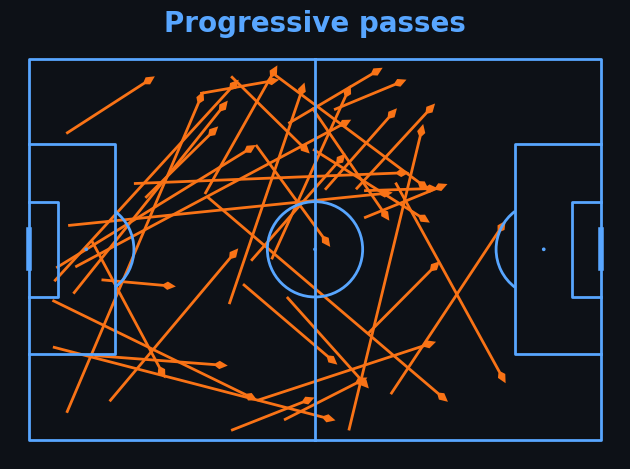

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch , Sbopen, VerticalPitch , FontManager


background_color = '#0d1117'
line_color = '#58a6ff'
arrow_color = '#f97316'
title_color = '#58a6ff'


prog_passes = prog_passes[
    (prog_passes['x'] >= 0) & (prog_passes['x'] <= 120) &
    (prog_passes['y'] >= 0) & (prog_passes['y'] <= 80) &
    (prog_passes['endX'] >= 0) & (prog_passes['endX'] <= 120) &
    (prog_passes['endY'] >= 0) & (prog_passes['endY'] <= 80)
]


pitch=Pitch(pitch_color=background_color, line_color=line_color,pitch_type='statsbomb', line_zorder=2,stripe=False)
fg,ax=pitch.draw()

for idx, row in prog_passes.iterrows():
    start_x, start_y=row['x'], row['y']
    end_x, end_y=row['endX'], row['endY']
    pitch.arrows(start_x, start_y, end_x, end_y,width=2, headwidth=3, headlength=3, color=arrow_color, ax=ax)


ax.set_title("Progressive passes", fontsize=20, color=title_color, fontweight='bold')

fg.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)
ax.spines['top'].set_color(line_color)
ax.spines['bottom'].set_color(line_color)
ax.spines['left'].set_color(line_color)
ax.spines['right'].set_color(line_color)
ax.xaxis.label.set_color(line_color)
ax.yaxis.label.set_color(line_color)
ax.tick_params(colors=line_color, which='both')
plt.show()

**PASS NETWORKS**

In [93]:
pass_events=pass_events.sort_values(['minute', 'second']).reset_index(drop=True)

pass_events['pass_recipient']=pass_events['name'].shift(-1)

pass_events['pass_recipient'].fillna('Unknown', inplace=True)


C:\Users\gerald wangai\AppData\Local\Temp\ipykernel_7128\396019959.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pass_events['pass_recipient'].fillna('Unknown', inplace=True)


In [95]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt

def create_pass_network(df, player_col='name', recipient_col='pass_recipient', x_col='x', y_col='y', min_passes=4):
    # Filter out rows where pass recipient is missing
    df = df[df[recipient_col].notna()]

    # Ensure coordinates are within StatsBomb pitch limits
    df[x_col] = df[x_col].clip(0, 120)
    df[y_col] = df[y_col].clip(0, 80)

    # Calculate average positions for each player
    player_positions = df.groupby(player_col).agg({x_col: 'mean', y_col: 'mean'}).reset_index()

    # Count the number of passes between players
    pass_counts = df.groupby([player_col, recipient_col]).size().reset_index(name='pass_count')

    # Filter out connections with fewer than min_passes
    pass_counts = pass_counts[pass_counts['pass_count'] >= min_passes]

    # Merge average positions for passing players
    pass_counts = pass_counts.merge(player_positions, left_on=player_col, right_on=player_col)
    pass_counts = pass_counts.merge(player_positions, left_on=recipient_col, right_on=player_col, suffixes=('', '_end'))

    # Create pitch and set figure size
    pitch = Pitch(pitch_type='statsbomb', pitch_color='black', line_color='white')
    fig, ax = plt.subplots(figsize=(10, 6))
    pitch.draw(ax=ax)

    # Plot player positions
    pitch.scatter(player_positions[x_col], player_positions[y_col], ax=ax, color='red', s=100, edgecolors='black', zorder=3)
    
    # Annotate player names
    for _, row in player_positions.iterrows():
        ax.text(row[x_col], row[y_col], row[player_col], fontsize=10, ha='center', va='center', color='white')

    # Plot pass connections within pitch boundaries
    for _, row in pass_counts.iterrows():
        start_x, start_y = row[x_col], row[y_col]
        end_x, end_y = row[x_col + '_end'], row[y_col + '_end']

        # Clip to ensure lines fit within pitch
        start_x, start_y = max(0, min(start_x, 120)), max(0, min(start_y, 80))
        end_x, end_y = max(0, min(end_x, 120)), max(0, min(end_y, 80))

        pitch.lines(start_x, start_y, end_x, end_y,
                    lw=row['pass_count'] / 2, color='white', ax=ax, zorder=2)

    ax.set_title('Pass Network Visualization', fontsize=16, color='white')
    plt.show()

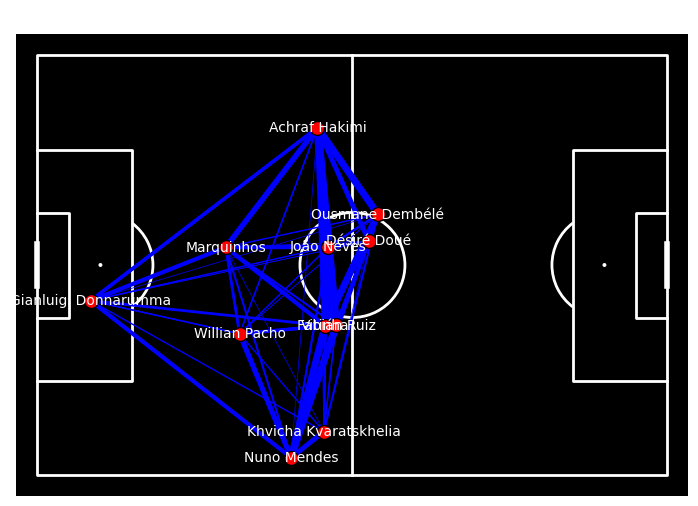

In [96]:
pass_network=create_pass_network(pass_events)